# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Cats-and-Dogs" data-toc-modified-id="Cats-and-Dogs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs</a></div><div class="lev2 toc-item"><a href="#Módulos-utilizados" data-toc-modified-id="Módulos-utilizados-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Módulos utilizados</a></div><div class="lev2 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Procedimento-de-treino" data-toc-modified-id="Procedimento-de-treino-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Procedimento de treino</a></div><div class="lev2 toc-item"><a href="#Funções-auxiliares" data-toc-modified-id="Funções-auxiliares-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Funções auxiliares</a></div><div class="lev2 toc-item"><a href="#Atributos-gerados-pela-ResNet" data-toc-modified-id="Atributos-gerados-pela-ResNet-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Atributos gerados pela ResNet</a></div><div class="lev3 toc-item"><a href="#Treino" data-toc-modified-id="Treino-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Treino</a></div><div class="lev3 toc-item"><a href="#Evolução-do-custo-e-acurácia" data-toc-modified-id="Evolução-do-custo-e-acurácia-152"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Evolução do custo e acurácia</a></div><div class="lev3 toc-item"><a href="#Classificações-equivocadas" data-toc-modified-id="Classificações-equivocadas-153"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Classificações equivocadas</a></div><div class="lev2 toc-item"><a href="#Ajuste-fino-nos-pesos-da-ResNet" data-toc-modified-id="Ajuste-fino-nos-pesos-da-ResNet-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Ajuste fino nos pesos da ResNet</a></div><div class="lev3 toc-item"><a href="#Treino" data-toc-modified-id="Treino-161"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Treino</a></div><div class="lev3 toc-item"><a href="#Evolução-do-custo-e-acurácia" data-toc-modified-id="Evolução-do-custo-e-acurácia-162"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Evolução do custo e acurácia</a></div><div class="lev3 toc-item"><a href="#Equívocos-no-conjunto-de-validação" data-toc-modified-id="Equívocos-no-conjunto-de-validação-163"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Equívocos no conjunto de validação</a></div><div class="lev3 toc-item"><a href="#Equívocos-no-conjunto-de-treino" data-toc-modified-id="Equívocos-no-conjunto-de-treino-164"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span>Equívocos no conjunto de treino</a></div><div class="lev3 toc-item"><a href="#Log-Loss" data-toc-modified-id="Log-Loss-165"><span class="toc-item-num">1.6.5&nbsp;&nbsp;</span>Log Loss</a></div><div class="lev3 toc-item"><a href="#Kaggle-submission" data-toc-modified-id="Kaggle-submission-166"><span class="toc-item-num">1.6.6&nbsp;&nbsp;</span>Kaggle submission</a></div>

# Cats and Dogs

Este notebook implementa um experimento de **transferência de conhecimento** (*"transfer learning"*)

## Módulos utilizados

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import sys
import time
import copy
import glob, shutil
import numpy as np
import numpy.random as nr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models

print('GPU available:', torch.cuda.is_available())

GPU available: True


## Dataset

In [2]:
def create_directories(top_dir, valid_split=0.25):
    all_pets = nr.permutation(np.array(glob.glob(os.path.join(top_dir, 'train', '*.jpg'))))
    all_cats = [pet for pet in all_pets if pet.split('/')[-1].startswith('cat')]
    all_dogs = [pet for pet in all_pets if pet.split('/')[-1].startswith('dog')]
    n_vcats, n_vdogs = int(valid_split*len(all_cats)), int(valid_split*len(all_dogs))
    
    train_cats = os.path.join(top_dir, 'train', 'cats')
    train_dogs = os.path.join(top_dir, 'train', 'dogs')
    valid_cats = os.path.join(top_dir, 'valid', 'cats')
    valid_dogs = os.path.join(top_dir, 'valid', 'dogs')
    os.makedirs(train_cats, exist_ok=True)
    os.makedirs(train_dogs, exist_ok=True)
    os.makedirs(valid_cats, exist_ok=True)
    os.makedirs(valid_dogs, exist_ok=True)
    
    for cat in all_cats[:n_vcats]: shutil.move(cat, valid_cats)
    for cat in all_cats[n_vcats:]: shutil.move(cat, train_cats)
    for dog in all_dogs[:n_vdogs]: shutil.move(dog, valid_dogs)
    for dog in all_dogs[n_vdogs:]: shutil.move(dog, train_dogs)


train: 18750, validation: 6250, test: 0 


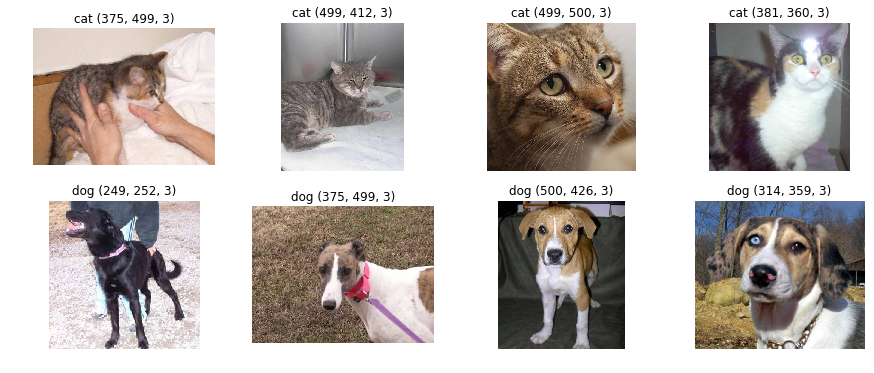

In [3]:
train_data_dir = '../../datasets/CatsDogsRedux/train'
valid_data_dir = '../../datasets/CatsDogsRedux/valid'
test_data_dir  = '../../datasets/CatsDogsRedux/test'

if not os.path.isdir(valid_data_dir):
    create_directories(train_data_dir)

cat_train_samples = glob.glob(train_data_dir + '/cats/*.jpg')
dog_train_samples = glob.glob(train_data_dir + '/dogs/*.jpg')
cat_valid_samples = glob.glob(valid_data_dir + '/cats/*.jpg')
dog_valid_samples = glob.glob(valid_data_dir + '/dogs/*.jpg')
    
nb_train_samples = len(cat_train_samples + dog_train_samples)
nb_valid_samples = len(cat_valid_samples + dog_valid_samples)
nb_test_samples  = len(glob.glob(test_data_dir + '/*.jpg'))

print(f'train: {nb_train_samples}, validation: {nb_valid_samples}, test: {nb_test_samples} ')

fig = plt.figure(figsize=(15,6))
for i, fn in enumerate(cat_train_samples[:4]):
    fig.add_subplot(2,4, i+1)
    img = plt.imread(fn)
    plt.imshow(img)
    plt.title('cat {}'.format(img.shape))
    plt.axis('off')
    
for i, fn in enumerate(dog_train_samples[:4]):
    fig.add_subplot(2,4, i+5)
    img = plt.imread(fn)
    plt.imshow(img)
    plt.title('dog {}'.format(img.shape))
    plt.axis('off')


In [4]:
batch_size = 20
img_width, img_height = 224, 224

def my_transforms(img):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

dsets = {
    'train': datasets.ImageFolder(train_data_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_data_dir, data_transforms['valid'])
}

dset_loaders = {
    'train': torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(dsets['valid'], batch_size=batch_size, shuffle=True)
}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

torch.Size([3, 224, 224]) torch.Size([20])


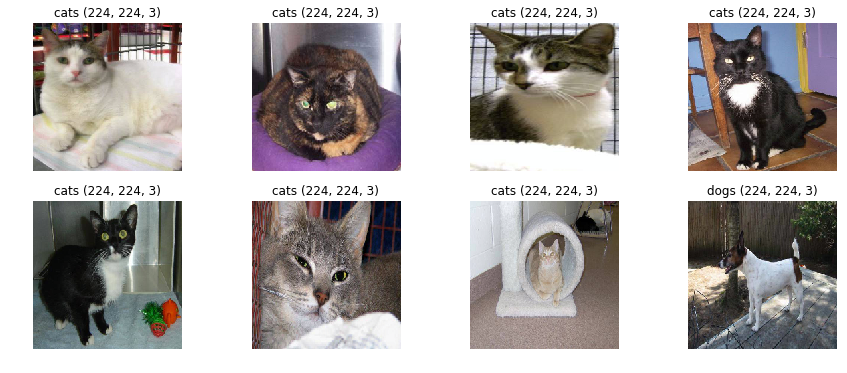

In [5]:
# Get a batch of training data
inputs, cls = next(iter(dset_loaders['train']))

print(inputs[8].shape, cls.shape)

fig = plt.figure(figsize=(15,6))
for i, j in enumerate(range(4)):
    fig.add_subplot(2,4, i+1)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')
    
for i, j in enumerate(range(4, 8)):
    fig.add_subplot(2,4, i+5)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')


## Procedimento de treino

In [6]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25, model_fn=None):
    since = time.time()

    if os.path.isfile(model_fn):
        model.load_state_dict(torch.load(model_fn))
    
    best_model = model
    best_acc = 0.0
    best_epoch = 0
    
    losses = dict(train=[], valid=[])

    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    # optimizer = lr_scheduler(optimizer, epoch)
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode

                t0 = time.time()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for data in dset_loaders[phase]:
                    # get the inputs
                    inputs, labels = data

                    # wrap them in Variable
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.data[0]
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dset_sizes[phase]
                epoch_acc = running_corrects / dset_sizes[phase]
                
                losses[phase].append((epoch_loss, epoch_acc))

                t1 = time.time()
                print('{} Loss: {:.4f} Acc: {:.4f}   {:.4f} min'.format(phase, epoch_loss, epoch_acc, (t1-t0)/60))

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model = copy.deepcopy(model)

            print()
    
    except KeyboardInterrupt:
        print('\nInterrupted!\n')
    
    finally:
        if model_fn is not None:
            torch.save(best_model.state_dict(), model_fn)
            print('Model saved as', model_fn)
            
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}  on epoch {}'.format(best_acc, best_epoch))
        
    return best_model, losses


In [7]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

## Funções auxiliares

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = denormalize(inp.numpy())
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plts are updated

def visualize_mismatches(model, dset='valid', num_images=12):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(dset_loaders[dset]):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            if preds[j] == labels.data[j]:
                continue
            images_so_far += 1
            ax = plt.subplot(num_images//4, 4, images_so_far)
            ax.axis('off')
            ax.set_title('pred/lab: {} / {}'.format(dset_classes[preds[j]], dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


## Atributos gerados pela ResNet

In [ ]:
model_name_1 = '../../models/cats-dogs-redux-1.model'

model_conv_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_1.fc.in_features
model_conv_1.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv_1 = model_conv_1.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv_1.fc.parameters(), lr=0.001, momentum=0.9)


### Treino

In [ ]:
try:
    model_conv_1, losses = train_model(model_conv_1, criterion, optimizer_conv, 
                                       exp_lr_scheduler, num_epochs=10, model_fn=model_name_1)
except KeyboardInterrupt:
    pass


Epoch 0/9
----------
train Loss: 0.0046 Acc: 0.9652   3.6411 min
valid Loss: 0.0026 Acc: 0.9797   1.1502 min

Epoch 1/9
----------
train Loss: 0.0045 Acc: 0.9647   3.4699 min
valid Loss: 0.0026 Acc: 0.9808   1.1501 min

Epoch 2/9
----------
train Loss: 0.0047 Acc: 0.9641   3.6675 min
valid Loss: 0.0029 Acc: 0.9754   1.0262 min

Epoch 3/9
----------
train Loss: 0.0045 Acc: 0.9652   3.5586 min
valid Loss: 0.0028 Acc: 0.9776   1.1525 min

Epoch 4/9
----------
train Loss: 0.0044 Acc: 0.9650   3.5164 min
valid Loss: 0.0027 Acc: 0.9786   1.0805 min

Epoch 5/9
----------
train Loss: 0.0045 Acc: 0.9642   3.6055 min
valid Loss: 0.0028 Acc: 0.9781   1.1406 min

Epoch 6/9
----------


### Evolução do custo e acurácia

In [ ]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
tlos = [l for l, a in losses['train']]
vlos = [l for l, a in losses['valid']]
plt.plot(tlos, label='train')
plt.plot(vlos, label='valid')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
tacc = [a for l, a in losses['train']]
vacc = [a for l, a in losses['valid']]
plt.plot(tacc, label='train')
plt.plot(vacc, label='valid')
plt.legend()
plt.grid()


### Classificações equivocadas

In [ ]:
visualize_mismatches(model_conv_1)

## Ajuste fino nos pesos da ResNet

In [ ]:
model_name_2 = '../../models/cats-dogs-redux-2.model'

if os.path.isfile(model_name_2):
    model_conv_2 = torchvision.models.resnet18(pretrained=False)
    num_ftrs = model_conv_2.fc.in_features
    model_conv_2.fc = nn.Linear(num_ftrs, 2)
    model_conv_2.load_state_dict(torch.load(model_name_2))

else:
    model_conv_2 = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model_conv_2.fc.in_features
    model_conv_2.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv_2 = model_conv_2.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
# optimizer_conv = optim.SGD(model_conv_2.parameters(), lr=0.0001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv_2.parameters(), lr=1e-4)


### Treino

In [ ]:
try:
    model_conv_2, losses = train_model(model_conv_2, criterion, optimizer_conv, 
                                       exp_lr_scheduler, num_epochs=10, model_fn=model_name_2)
except KeyboardInterrupt:
    pass


### Evolução do custo e acurácia

In [ ]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
tlos = [l for l, a in losses['train']]
vlos = [l for l, a in losses['valid']]
plt.plot(tlos, label='train')
plt.plot(vlos, label='valid')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
tacc = [a for l, a in losses['train']]
vacc = [a for l, a in losses['valid']]
plt.plot(tacc, label='train')
plt.plot(vacc, label='valid')
plt.legend()
plt.grid()


### Equívocos no conjunto de validação

In [ ]:
visualize_mismatches(model_conv_2)

### Equívocos no conjunto de treino

In [ ]:
visualize_mismatches(model_conv_2, dset='train')

### Log Loss

In [ ]:
vprobas = []
vlabels = []
for i, data in enumerate(dset_loaders['valid']):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = model_conv_2(inputs)
    probas = nn.Softmax()(outputs)
    vlabels.append(labels.cpu().data.numpy())
    vprobas.append(probas.cpu().data.numpy())
    
vprobas = np.vstack(vprobas)
vlabels = np.hstack(vlabels)


In [ ]:
def logloss(p, t):
    loss = t * np.log(p + 1e-10) + (1 - t) * np.log(1 - p + 1e-10)
    return -loss.mean()

logloss(vprobas[:, 1], vlabels)

### Kaggle submission

In [ ]:
test_dset = datasets.ImageFolder(test_data_dir, data_transforms['valid'])
test_size = len(test_dset)

print(test_size)

In [ ]:
pdict = {}
proba_array = 5.5 * np.ones((test_size,), np.float32)
batch_tensor = torch.Tensor(batch_size, 3, img_height, img_width)
for i in range(0, test_size, batch_size):
    imgids = []
    for j in range(batch_size):
        batch_tensor[j] = test_dset[i+j][0]
        imgids.append(int(test_dset.imgs[i+j][0].split('/')[-1][:-4]))
        
    if use_gpu:
        inputs = Variable(batch_tensor.cuda())
    else:
        inputs = Variable(batch_tensor)

    outputs = model_conv_2(inputs)
    probas = nn.Softmax()(outputs)
    assert np.allclose(probas.data.sum(), batch_size), ('probs should sum to one', probas.data.sum(), i)
    
    for j in range(batch_size):
        index = imgids[j]
        proba_array[index-1] = probas.data[j, 1]
        pdict[index] = probas.data[j, 1]


In [ ]:
with open('kaggle_submission.csv', 'w') as sub:
    print('id,label', file=sub)
    for i in range(test_size):
        p = proba_array[i]
        print('{},{:.8f}'.format(i+1, p), file=sub)
